# Problem A: Building a Language Model
## 1 Preprocessing the data
### Question1 & 2
Create a list of all the news;
Preprocess the data by transforming the list of sentences into a list of sequences of integers, via a dictionary that maps the words to integers. (For each sentence, add the token ”Start” at the beginning of the sentence and ”End” at the end.)


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.special import softmax
import random
from IPython.display import Image

In [3]:
# #===============================
# # preprocess
# #===============================
data = pd.read_csv("./data/RedditNews.csv")
news = data["News"].values
MAX_VOCAB = 9999

tokenizer = Tokenizer(num_words = MAX_VOCAB,
                      oov_token = "UNK",
                     filters = '!"#$%&()*+,-./:;<=>?[\\]^_`{|}~\t\n',
                     lower = True)

tokenizer.fit_on_texts(news)
seqs = tokenizer.texts_to_sequences(news)


word_index= {}
for k,v in tokenizer.word_index.items():
    if v < MAX_VOCAB:
        word_index[k] = v

word_index["START"] = 0
word_index["END"] = MAX_VOCAB

index_word = {v:k for k,v in word_index.items()}
V_VOCAB = len(index_word)
# 10000

## 2 Building a Language Model on Reddit News

### Question 3

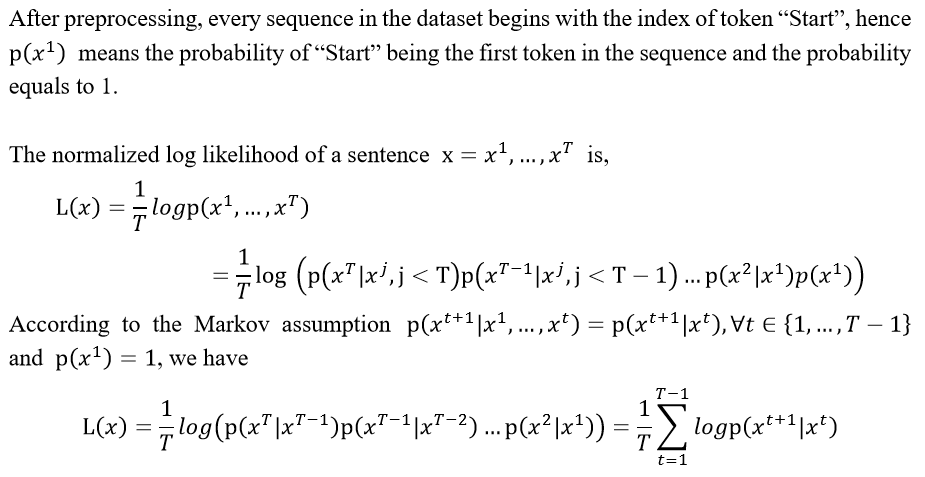

In [5]:
Image(filename='./screenshots/Q3.png',  width=600)

## 2.1 A Markov Model
### Question 4

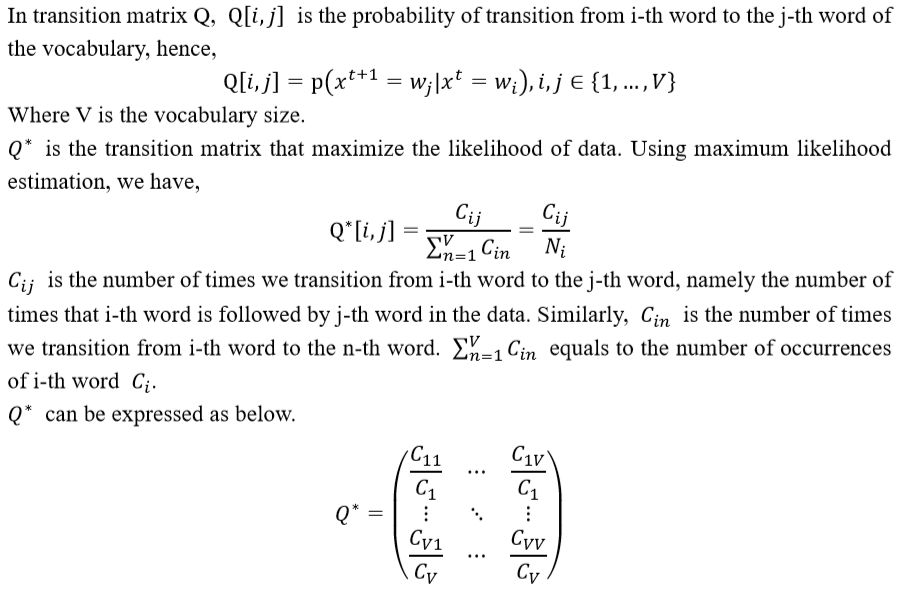

In [6]:
Image(filename='./screenshots/Q4.png',  width=600)

### Question 5

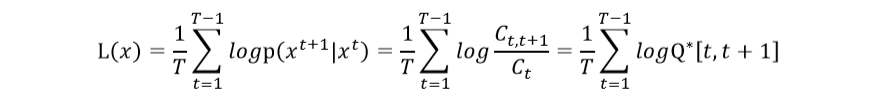

In [7]:
Image(filename='./screenshots/Q5.png',  width=600)

### Question 6
Estimate the matrix Q∗ on the Reddit News data

We saved the Q* matrix at "./data/Q_star.npy"

In [5]:
sequencesQ6 = []
for sequence in seqs:
    sequencesQ6.append([0] + sequence + [MAX_VOCAB])

# checkpoint
np.save("./data/sequencesQ6.npy",sequencesQ6)
sequencesQ6 = np.load("./data/sequencesQ6.npy")

def get_trans(data,V):
    word_count = np.zeros(V) #Ci
    bigram_count = np.zeros((V,V)) #Cij
    for seq in data:
        for i,w in enumerate(seq):
            word_count[w]+=1 #w-th word
            if i!=len(seq)-1:
                bigram_count[w][seq[i+1]]+=1    
    for i in range(bigram_count.shape[0]):
        bigram_count[i,:] /= word_count[i]
    return bigram_count

# checkpoint
Q_star = get_trans(sequencesQ6 ,V_VOCAB)
np.save("./data/Q_star.npy",Q_star)
Q_star = np.load("./data/Q_star.npy")


print("Q* example:",f"transition from START to a",Q_star[word_index["START"]][word_index["a"]])
print("Q* example:",f"transition from attack to END",Q_star[word_index["attack"]][word_index["END"]])
print("Q* example:",f"transition from START to START",Q_star[word_index["START"]][word_index["START"]])


Q* example: transition from START to a 0.018435496141723726
Q* example: transition from attack to END 0.1334760885082084
Q* example: transition from START to START 0.0


### Question 7
The result from code is as below. From the result, we can conclude that the normalized log likelihoods of true sentences from the real world are larger than the likelihoods of fake sentences. It means that it is more likely to see the true sentences than the fake sentences.



In [7]:

def cal_likelihood(sent,dic_wordindex,Q_star):
    eps = 1.0e-10 #prevent -inf
    T = len(sent)
    lx = 0
    for t in range(T-1): #t<=T-1
        lx+=np.log(Q_star[sent[t]][sent[t+1]]+eps) #in case of Q*[i,j]==0, thus +eps
    return lx/T

random.seed(42) #42 is randomly picked, we can set anynumber in the seed, only to make the results consist
true_sentences = random.sample(list(sequencesQ6),5)
print("5 sentences from corpus");print()
for sent in true_sentences:
    sent0 = " ".join([index_word[i_int] for i_int in sent])
    print(f"normalized log likelihood = {cal_likelihood(sent,word_index,Q_star)} for sentence: {sent0}")
    print()

print()


def get_fake(vocab,seed,length):
    random.seed(seed)
    seq = random.sample(vocab,length)
    return seq

int_vocab = list(index_word.keys())
fake_sentence1 = get_fake(int_vocab,1,20) #seed and length are randomly picked
fake_sentence2 = get_fake(int_vocab,2,len(true_sentences[1]))
fake_sentence3 = get_fake(int_vocab,3,len(true_sentences[2]))
fake_sentence4 = get_fake(int_vocab,4,len(true_sentences[3]))
fake_sentence5 = get_fake(int_vocab,5,len(true_sentences[4]))
fake_sentences = [fake_sentence1,fake_sentence2,fake_sentence3,fake_sentence4,fake_sentence5]
print("5 fake sentences");print()
for sent in fake_sentences:
    sent0 = " ".join([index_word[i_int] for i_int in sent])
    print(f"normalized log likelihood = {cal_likelihood(sent,word_index,Q_star)} for sentence: {sent0}") 
    print()




5 sentences from corpus

normalized log likelihood = -4.018777752330216 for sentence: START france awards highest honour to UNK wwii UNK living in new zealand END

normalized log likelihood = -4.1491542463578694 for sentence: START salman rushdie iranian state media renew fatwa on UNK UNK author with 600 000 bounty END

normalized log likelihood = -4.1520199419452695 for sentence: START azerbaijan army officer shot dead by armenian sniper END

normalized log likelihood = -4.384643853447296 for sentence: START india UNK down on gang rape protests pm appeals for calm indian authorities UNK movement in the heart of the capital shutting roads and railway stations in a bid to restore law and order after police fought UNK battles with protesters enraged by the gang rape of a young woman END

normalized log likelihood = -4.861406689732913 for sentence: START 7 dead 61 injured following protest after venezuela election END


5 fake sentences

normalized log likelihood = -21.874558383443436 for

# 2.2 Shallow Neural Network 
### Question 8
The shape of $H_i$ : ($T_{i-1} \times D$)

The shape of $P_i$ : ($T_{i-1} \times V$)

### Question 9

$\because H_i = 
 \left[
 \begin{matrix}
   (h_i^1)^T \\
   (h_i^2)^T \\ 
   \vdots \\
   (h_i^{T_i-1})^T  
  \end{matrix}
  \right] 
$
$,\qquad h_i^t = tanh(W_1^T\hat{x}_i^t)$
$,\qquad (h_i^t)^T = (tanh(W_1^T\hat{x}_i^t))^T = tanh((\hat{x}_i^t)^TW_1)$

$\therefore H_i = 
 \left[
 \begin{matrix}
   \text{tanh}((\hat{x}_i^1)^TW_1)) \\
   \text{tanh}((\hat{x}_i^2)^TW_1)) \\ 
   \vdots \\
   \text{tanh}((\hat{x}_i^{T_i-1})^TW_1)) 
  \end{matrix}
  \right] = 
  \text{tanh}\left( \left[
 \begin{matrix}
   (\hat{x}_i^1)^T  \\
   (\hat{x}_i^2)^T \\ 
   \vdots \\
   (\hat{x}_i^{T_i-1})^T 
  \end{matrix}
  \right]\times W_1\right) =
  \text{tanh}(F_iW_1)
 $
 
 $\because P_i = 
 \left[
 \begin{matrix}
   (p_i^1)^T \\
   (p_i^2)^T \\ 
   \vdots \\
   (p_i^{T_i-1})^T  
  \end{matrix}
  \right] 
$
$,\qquad p_i^t = softmax(W_2^T\hat{h}_i^t)$
$,\qquad (p_i^t)^T = (softmax(W_2^T\hat{h}_i^t))^T = softmax((\hat{h}_i^t)^TW_2)$

$\therefore P_i = 
 \left[
 \begin{matrix}
   \text{softmax}((\hat{h}_i^1)^TW_2)) \\
   \text{softmax}((\hat{h}_i^2)^TW_2)) \\ 
   \vdots \\
   \text{softmax}((\hat{h}_i^{T_i-1})^TW_2)) 
  \end{matrix}
  \right] = 
  \text{softmax}\left( \left[
 \begin{matrix}
   (\hat{h}_i^1)^T  \\
   (\hat{h}_i^2)^T \\ 
   \vdots \\
   (\hat{h}_i^{T_i-1})^T 
  \end{matrix}
  \right]\times W_2\right) =
  \text{softmax}(H_iW_2)
 $

### Question 10
 
$\because$ Loss Function $J_i =-\frac{1}{T_i-1}log(L_i)$
$,\quad L_i = \prod_{t=1}^{T_i-1}P(y_i^t|x_i^t)$ 
$,\quad P(y_i^t|x_i^t) = \prod_{v=1}^{V}(p_i^t[v])^{\hat{y}_i^t[v]}$

$\therefore J_i = -\frac{1}{T_i-1}\sum_{t=1}^{T_i-1}\sum_{v=1}^{V}\hat{y}_i^t[v]log(p_i^t[v])$


### Question 11
$\because F_i \in R^{(T_i-1) \times V},\ Y_i \in R^{(T_i-1) \times V},\ P_i \in R^{(T_i-1) \times V},\ H_i \in R^{(T_i-1) \times D},\ W_2 \in R^{D \times (T_i-1)}$

$\therefore G_i^1 =H_i^T(P_i - Y_i) \in R^{D\times V},$
$\quad G_i^2  = F_i^T[(P_i-Y_i)W_2^T)\cdot (N_i - H_i\cdot H_i)] \in R^{V\times D}$

$\because W_1 \in R^{V \times D},\quad W_2 \in R^{D \times V}$

$\therefore G_i^1$ represents $\nabla_{W_2}J_i,\quad G_i^2$ represents $\nabla_{W_1}J_i$.

### Question 12
Train the neural network for one epoch using the gradient descent as required. Store losses in a list.

In [1]:
# one-hot encoding
def vectorize(seq, V, xy_flag):
  tensor_data = np.zeros((len(seq)-1,V))
  seq = seq[:-1] if xy_flag == 'x' else seq[1:]
  for it, idx in enumerate(seq):
      tensor_data[it,idx] = 1  
  return tensor_data

In [3]:
# shuffle
random.seed(33)
random.shuffle(seqs)
sequences = []
for sequence in seqs:
    sequences.append([0] + sequence + [MAX_VOCAB])

print(max([len(sequence) for sequence in sequences]))
print(len(sequences))


67
73608


In [4]:
# checkpoint
np.save("./data/Q8.npy",np.array(sequences))
sequences = np.load("./data/Q8.npy").tolist()

In [5]:
# train test split
seqs_train = sequences[:int(len(sequences)*0.6)]
seqs_test = sequences[int(len(sequences)*0.6):]
print(len(seqs_train));print(len(seqs_test))

44164
29444


In [11]:
# Initialization
V_VOCAB = 10000; D = 16; learning_rate = 0.01; loss_list = []

W1 = np.zeros(shape = (V_VOCAB, D))
W2 = np.zeros(shape = (D, V_VOCAB))

In [12]:
# train
for i_seq in range(0,len(seqs_train)):
    seq = seqs_train[i_seq]
    F = vectorize(seq,V_VOCAB,'x')
    Y = vectorize(seq,V_VOCAB,'y')
    H = np.tanh(F.dot(W1))
    prob = softmax(H.dot(W2)) 
    loss = -1/(len(seq)-1)*sum(sum(Y*np.log(prob+1e-10)))
    loss_list.append(loss)
    gW_2 = H.T.dot(prob-Y)
    gW_1 = F.T.dot((prob-Y).dot(W2.T)*(np.ones(H.shape)-H*H))    
    W2 -= learning_rate*gW_2 # D x (2*context_size)
    W1 -= learning_rate*gW_1 # D
    learning_rate -= 0.01/len(seqs_train)
    if i_seq%1000==0:
        print(i_seq,"/",len(seqs_train))

0 / 44164
1000 / 44164
2000 / 44164
3000 / 44164
4000 / 44164
5000 / 44164
6000 / 44164
7000 / 44164
8000 / 44164
9000 / 44164
10000 / 44164
11000 / 44164
12000 / 44164
13000 / 44164
14000 / 44164
15000 / 44164
16000 / 44164
17000 / 44164
18000 / 44164
19000 / 44164
20000 / 44164
21000 / 44164
22000 / 44164
23000 / 44164
24000 / 44164
25000 / 44164
26000 / 44164
27000 / 44164
28000 / 44164
29000 / 44164
30000 / 44164
31000 / 44164
32000 / 44164
33000 / 44164
34000 / 44164
35000 / 44164
36000 / 44164
37000 / 44164
38000 / 44164
39000 / 44164
40000 / 44164
41000 / 44164
42000 / 44164
43000 / 44164
44000 / 44164


In [7]:
# checkpoint: loss list
np.save("./data/loss_list.npy",np.array(loss_list))
loss_list = np.load("./data/loss_list.npy")

### Question 13
Using an EWMA, plot a smooth version of the list of losses associated with each update of the Gradient Descent.

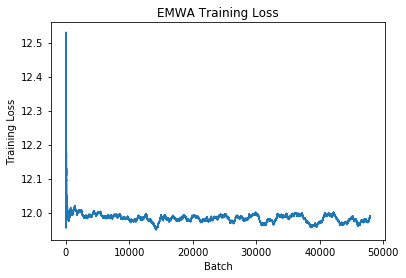

In [8]:
loss_ewma = pd.Series(loss_list).ewm(halflife=1000).mean()
plt.plot(loss_ewma)
plt.title("EMWA Training Loss")
plt.xlabel("Batch")
plt.ylabel("Training Loss")
plt.show()

###  Question 14
W1 is the embedding matrix that we created from the trained neural network. We save W1 in "./data/W1.npy"

In [9]:
# embedding matrix checkpoint
np.save("./data/W1.npy",W1)
W1 = np.load("./data/W1.npy")

# Problem B: Building a Sentiment Analysis Model 

### Question 15
We try to build a sentiment analysis model given a dataset of tweets and their sentiment. First, we explore the dataset to learn the characteristics of tweets, such as the average length of one tweet, the vocabulary included in the dataset, etc. Second, we index each word according to its frequency and store them in a dictionary. Finally, we try to train different models with various embeddings, and compare their performance.


In [3]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import collections
import nltk
nltk.download('punkt')
import tensorflow as tf
from keras.preprocessing import sequence
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential # to define a stack of layers
from keras.layers import Input, Activation, Dense, Dropout # The dense layer
import keras.utils
from keras.preprocessing.text import Tokenizer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


## Data Exploration
In this part, we load the TweetSentiment.csv, explore this dataset, and index the vocabularies by frequency. Then we put them into a dictionary.

In [5]:
# Import data
data = pd.read_csv("./gdrive/My Drive/ml/TweetSentiment.csv")
# Learn the shape of the datasets
print("The shape of tweet dataset is: ",data.shape)
# Have a look at the first 10 rows
data.head(10)

The shape of tweet dataset is:  (28440, 2)


,cleaned_tweets,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1
5,david butler favorit fang stock realmoneysod a...,0
6,miss convo one favorit thinker,0
7,u intellig document nelson mandela made public,0
8,senat want emerg alert go netflix spotifi etc,1
9,hedg fund manag marc larsi say bitcoin k possibl,0


In [6]:
# Learn the distribution of sentiment in this dataset
data.groupby(by="sentiment").count()

,cleaned_tweets
sentiment,
-1,2598
0,17324
1,8512


This dataset includes 28,440 tweets in total. We assume that all of these tweets are cleaned, which means that no more preprocessing work is needed. Each tweet is classified into three sentiments: positive(+1), neutral(0), negative(-1). We find that this dataset is imbalanced. Most of them are neutral, 17,324 out of 28,440, which means we should transform it into balanced data later when training the model.

The average length of these tweets is:  10.576969057665261
The number of vocabulary included is:  14390


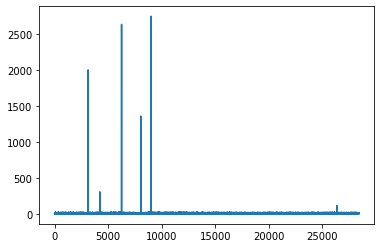

In [7]:
# Data exploration: observe the length and words in the tweets
tweets = data.cleaned_tweets.values
length = []
word_freq = collections.Counter()
for tweet in tweets:
    words = nltk.word_tokenize(str(tweet))
    length.append(len(words))
    for word in words:
        word_freq[word] += 1

plt.plot(length)
print('The average length of these tweets is: ',np.mean(length))
print('The number of vocabulary included is: ', len(word_freq))

As is shown in the above figure, a few tweets are extremely long sentences, which include over 2,500 words. However, most of them are short sentences, with an average length of 10 words. In total, these tweets cover 14,390 different vocabularies. Next, we need to index these vocabularies through creating a dictionary.

In [8]:
# Index the most frequently used words in tweets
max_features = 3000
word2index = {x[0]:(i+2) for i,x in enumerate(word_freq.most_common(max_features))}
word2index['PAD'] = 0
word2index['UNK'] = 1
index2word = {v:k for k,v in word2index.items()}
word2index.items()

dict_items([('rt', 2), ('inc', 3), ('amp', 4), ('stock', 5), ('earn', 6), ('analyst', 7), ('price', 8), ('trade', 9), ('share', 10), ('ep', 11), ('expect', 12), ('group', 13), ('hold', 14), ('option', 15), ('buy', 16), ('short', 17), ('new', 18), ('today', 19), ('invest', 20), ('regist', 21), ('binanc', 22), ('us', 23), ('high', 24), ('rate', 25), ('sale', 26), ('million', 27), ('week', 28), ('bonu', 29), ('join', 30), ('co', 31), ('target', 32), ('see', 33), ('sell', 34), ('get', 35), ('compani', 36), ('energi', 37), ('call', 38), ('q', 39), ('alert', 40), ('top', 41), ('corp', 42), ('market', 43), ('financi', 44), ('corpor', 45), ('zack', 46), ('manag', 47), ('posit', 48), ('nflx', 49), ('interest', 50), ('research', 51), ('announc', 52), ('maxpain', 53), ('head', 54), ('day', 55), ('lower', 56), ('jul', 57), ('capit', 58), ('per', 59), ('post', 60), ('volum', 61), ('estim', 62), ('x', 63), ('file', 64), ('bullish', 65), ('amzn', 66), ('llc', 67), ('downgrad', 68), ('v', 69), ('news'

We decide to include 3000 words in the vocabulary because when we include more, the frequency will be reduced to 10 times. Therefore, we drop these low-frequency words and use "UNK" to replace them, so that our dictionary can be more meaningful.

In [9]:
# Transform tweets into index
X = np.empty(len(data),dtype=list)
i=0
for tweet in tweets:
    seqs =[]
    words = nltk.word_tokenize(str(tweet))
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index['UNK'])
    X[i] = seqs
    i+=1
print(X)

[list([369, 796, 2133, 471, 1630, 1, 1505, 142, 72, 2691, 2802])
 list([8, 2508, 1279, 98, 476, 268, 2134, 24, 1, 2583, 310, 1195])
 list([160, 244, 1, 1]) ...
 list([2, 187, 1, 1459, 958, 1105, 1, 96, 505, 1322, 223, 101, 261])
 list([101]) list([2797, 1625, 8, 22, 198, 76, 732, 79])]


In the above algorithms, we transform each tweet into its index in the dictionary. As we can see from the list X, the length of tweets is not uniform. In the next step, we try to cut words if one tweet has over 10 words (the average length), and fill those who have fewer than 10 words with 0. Then all of the tweets have the same length, as is shown in the list X1. 

In [10]:
# Set the length of each tweet as 10
max_length = 10
X1 = sequence.pad_sequences(X, maxlen=max_length,padding='post',truncating='post')
print(X1)

[[ 369  796 2133 ...  142   72 2691]
 [   8 2508 1279 ...   24    1 2583]
 [ 160  244    1 ...    0    0    0]
 ...
 [   2  187    1 ...   96  505 1322]
 [ 101    0    0 ...    0    0    0]
 [2797 1625    8 ...   79    0    0]]


## Using one hot encoding to classify emotions

We start with the simple one hot encoding. In this part, we form the one hot vector for each tweet, split the whole dataset into the train and test datasets, and train a deep learning model with 4 dense layers, which achieves an accuracy of 92.94%. 

In [11]:
# Transform index into one hot vectors
def vectorize(sequences, V):
  # length of sequences
  N = len(sequences)
  # Initialize the tensor data of shape (N, V) with zeros
  tensor_data = np.zeros((N, V))
  # Add the ones in the tensor data
  for i, sequence in enumerate(sequences):
    tensor_data[i, sequence] = 1.
  return tensor_data
one_hot_vec = vectorize(X1,3002)
print(one_hot_vec.shape)

(28440, 3002)


Then we split these tweets into train and test datasets. We decide to use 70% tweets to train our models and set 30% data aside for testing purpose. As we discussed before, the tweet dataset is quite imbalanced, to get the true accuracy of our model, we need to train our model with balanced data. Here, we use the oversampling method to make use of each tweet. As is shown in the following part, our train dataset include 12,105 tweets in each sentiment target. Also, since this is not a binary classification, we should transform the sentiment (-1, 0, 1) into dummy variables.

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(one_hot_vec, data.sentiment, test_size=0.3, random_state=0)

# Use oversampling method to balance the training set
ros = RandomOverSampler(random_state=0)
X_resampled,y_resampled = ros.fit_sample(X_train,y_train)

# Check the number of each sentiment
print(collections.Counter(y_resampled))

# Transform the tri-class into dummy variables
y_resampled = keras.utils.to_categorical(y_resampled,num_classes=3)
y_test = keras.utils.to_categorical(y_test,num_classes=3)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 12105, 1: 12105, -1: 12105})


We add three dense layers with an output dimension of 16 in our model, and after each dense layer, we add a dropout layer to prevent the overfitting problem. We set 20 batches with a size of 64. The one hot encoding method achieves an accuracy of 92.94% in the test dataset.

In [14]:
# One hot vector model
V = len(word2index)
model = Sequential()
model.add(Dense(16,activation='softmax',input_shape=(V,)))
model.add(Dropout(0.2))
model.add(Dense(16,activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
# model.add(Activation('softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_resampled,y_resampled,batch_size=64,epochs=20,validation_split=0.3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                48048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

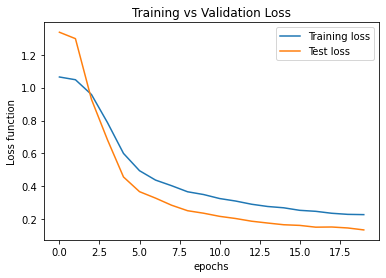

In [15]:
# Plot in-the-sample loss and out-of-sample loss
history.history.keys()
# fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"], label = "Test loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

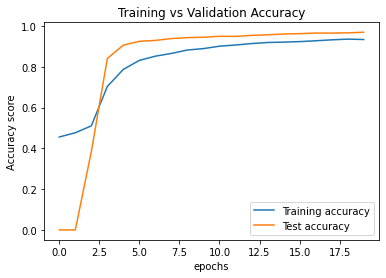

In [16]:
# Plot in-the-sample accuracy and out-of-sample accuracy
plt.plot(history.history["accuracy"], label = "Training accuracy")
plt.plot(history.history["val_accuracy"], label = "Test accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [17]:
# Evaluate the final model on the test data
oos = model.evaluate(X_test, y_test)
print("The OOS loss is: ", oos[0], " The OOS accuracy is: ", oos[1])

8532/8532 [==============================] - 1s 60us/step
The OOS loss is:  0.2481823313266975  The OOS accuracy is:  0.9294421076774597


As is shown in the above loss and accuracy figures, the model's accuracy is close to 0 at the first batch. However, the model improves quickly after 3 batches, with an accuracy of 84% in the validation dataset. Finally, we test the model using the out of sample dataset, which gives an accuracy of 92.94%.

## Using LSTM layers to classify emotions

We wonder whether RNN models could be more useful when classifying emotions. In this part, we try LSTM model with a random embedding matrix. We set two LSTM layers with an output dimension of 16 in this model. LSTM gives us an oos accuracy of 93%. 

In [18]:
V = len(word2index)
D = 200
d = 16

model2 = Sequential()
model2.add(Embedding(input_dim=V,output_dim=D,input_length=max_length))
model2.add(LSTM(output_dim=d, dropout=0.2, return_sequences=True))
model2.add(LSTM(output_dim=d, dropout=0.2, return_sequences=False))
model2.add(Dense(3, activation="softmax"))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(dropout=0.2, return_sequences=True, units=16)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(dropout=0.2, return_sequences=False, units=16)`
  


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 200)           600400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 16)            13888     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 616,451
Trainable params: 616,451
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, data.sentiment, test_size=0.3, random_state=0)
# Use oversampling method to balance the training set
ros = RandomOverSampler(random_state=0)
X_resampled1,y_resampled1 = ros.fit_sample(X_train1,y_train1)
# Check the number of each sentiment
print(collections.Counter(y_resampled1))

# Transform the tri-class into dummy variables
y_resampled1 = keras.utils.to_categorical(y_resampled1,num_classes=3)
y_test1 = keras.utils.to_categorical(y_test1,num_classes=3)

Counter({0: 12105, 1: 12105, -1: 12105})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
history2 = model2.fit(X_resampled1,y_resampled1,batch_size=64,epochs=20,validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25420 samples, validate on 10895 samples
Epoch 1/20
25420/25420 [==============================] - 17s 663us/step - loss: 0.4640 - accuracy: 0.8192 - val_loss: 0.2549 - val_accuracy: 0.9189
Epoch 2/20
25420/25420 [==============================] - 16s 636us/step - loss: 0.1903 - accuracy: 0.9402 - val_loss: 0.2093 - val_accuracy: 0.9320
Epoch 3/20
25420/25420 [==============================] - 16s 627us/step - loss: 0.1429 - accuracy: 0.9546 - val_loss: 0.1527 - val_accuracy: 0.9529
Epoch 4/20
25420/25420 [==============================] - 16s 632us/step - loss: 0.1101 - accuracy: 0.9663 - val_loss: 0.1199 - val_accuracy: 0.9625
Epoch 5/20
25420/25420 [==============================] - 16s 632us/step - loss: 0.0905 - accuracy: 0.9718 - val_loss: 0.1111 - val_accuracy: 0.9614
Epoch 6/20
25420/25420 [==============================] - 16s 632us/step - loss: 0.0787 - accuracy: 0.9750 - val_loss: 0.0797 - val_accuracy: 0.9748
Epoch 7/20
25420/25420 [==============================] 

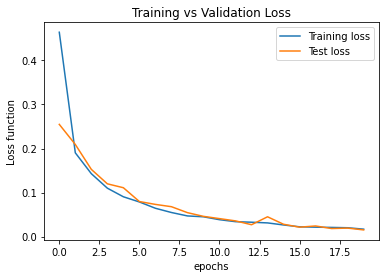

In [21]:
# Plot in-the-sample loss and out-of-sample loss
history2.history.keys()
plt.plot(history2.history["loss"], label = "Training loss")
plt.plot(history2.history["val_loss"], label = "Test loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

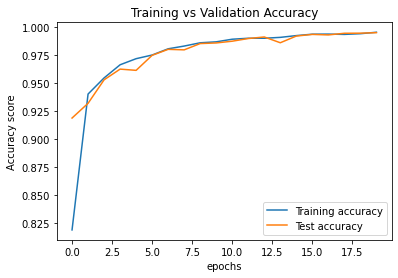

In [22]:
# Plot in-the-sample accuracy and out-of-sample accuracy
plt.plot(history2.history["accuracy"], label = "Training accuracy")
plt.plot(history2.history["val_accuracy"], label = "Test accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [23]:
oos2 = model2.evaluate(X_test1, y_test1)
print("The OOS loss is: ", oos2[0], " The OOS accuracy is: ", oos2[1])

8532/8532 [==============================] - 1s 140us/step
The OOS loss is:  0.42810926359104046  The OOS accuracy is:  0.9300281405448914


Different from the previous model, LSTM achieves high accuracy from the very beginning, with a much better performance in the validation dataset than the training dataset.

## Using LSTM with the Pre-trained Embedding: GloVe

We also want to learn whether pre-trained embeddings could improve the model performance. In this part, we download the pre-trained embeddings, GloVe, which is trained with tweet data and transform each word into a 200 dimensional vector. Then we rerun the LSTM model and get an oos accuracy of 94%, 1% higher than the one without pre-trained embeddings. Therefore, introducing pre-trained embeddings does help us to perform sentiment analysis, yet not very much. 


Extra data source for your perusal: https://drive.google.com/file/d/1qlfwDUAfLVGrkyMvrTbXnSYOCCYyVpJ-/view?usp=sharing

In [0]:
# Load GloVe
filename = './gdrive/My Drive/AP/glove.twitter.27B.200d.txt'
embeddings_index = {}
f = open(filename,'r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

We need to check whether the downloaded embeddings cover most of the words in our tweet dataset. It turns out 84.14% of vocabulary is covered by GloVe, which is not bad.

In [26]:
# Check the coverage of GloVe
from tqdm import tqdm
iv = {}
oov = {}
# k=0
# i=0
for w in tqdm(word2index.keys()):
  try:
    iv[w] = embeddings_index[w]
    # k+=vocab[w]
  except:
    oov[w] = word2index[w]
    # i+= vocab[w]
    pass
print("Coverage rate is: ", len(iv)/len(word2index))

100%|██████████| 3002/3002 [00:00<00:00, 629879.97it/s]

Coverage rate is:  0.8414390406395736


Then we map each word to its embedding in GloVe and store them in a matrix with a shape of (3002, 200).

In [28]:
# Create the embedding matrix
def build_matrix(embeddings_index,word_index):
  embedding_matrix = np.zeros((V, 200))
  for word, i in tqdm(word_index.items()):
      if i >= max_features: continue
      try:
          embedding_vector = embeddings_index[word]
      except:
          embedding_vector = embeddings_index["unknown"]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
m = build_matrix(embeddings_index,word2index)
m.shape

100%|██████████| 3002/3002 [00:00<00:00, 329029.49it/s]


(3002, 200)

In [29]:
V = len(word2index)
D = 200
d = 16

model3 = Sequential()
model3.add(Embedding(input_dim=V,output_dim=D,input_length=max_length,weights=[m]))
model3.add(LSTM(output_dim=d, dropout=0.2, return_sequences=True))
model3.add(LSTM(output_dim=d, dropout=0.2, return_sequences=False))
model3.add(Dense(3, activation="softmax"))
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model3.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(dropout=0.2, return_sequences=True, units=16)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(dropout=0.2, return_sequences=False, units=16)`
  


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 200)           600400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            13888     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 51        
Total params: 616,451
Trainable params: 616,451
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history3 = model3.fit(X_resampled1,y_resampled1,batch_size=64,epochs=20,validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25420 samples, validate on 10895 samples
Epoch 1/20
25420/25420 [==============================] - 17s 655us/step - loss: 0.6129 - accuracy: 0.7411 - val_loss: 0.3586 - val_accuracy: 0.8698
Epoch 2/20
25420/25420 [==============================] - 16s 630us/step - loss: 0.2746 - accuracy: 0.9083 - val_loss: 0.2342 - val_accuracy: 0.9162
Epoch 3/20
25420/25420 [==============================] - 16s 645us/step - loss: 0.2023 - accuracy: 0.9314 - val_loss: 0.1964 - val_accuracy: 0.9322
Epoch 4/20
25420/25420 [==============================] - 16s 632us/step - loss: 0.1675 - accuracy: 0.9443 - val_loss: 0.1562 - val_accuracy: 0.9480
Epoch 5/20
25420/25420 [==============================] - 16s 638us/step - loss: 0.1413 - accuracy: 0.9548 - val_loss: 0.1728 - val_accuracy: 0.9425
Epoch 6/20
25420/25420 [==============================] - 16s 633us/step - loss: 0.1225 - accuracy: 0.9592 - val_loss: 0.1148 - val_accuracy: 0.9601
Epoch 7/20
25420/25420 [==============================] 

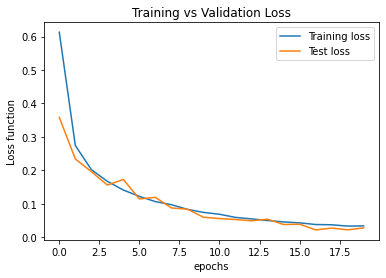

In [31]:
# Plot in-the-sample loss and out-of-sample loss
history3.history.keys()
plt.plot(history3.history["loss"], label = "Training loss")
plt.plot(history3.history["val_loss"], label = "Test loss")
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

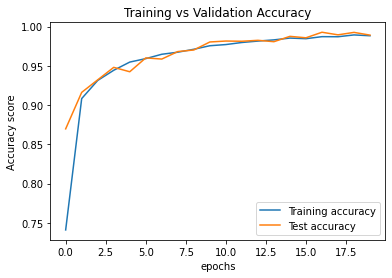

In [32]:
# Plot in-the-sample accuracy and out-of-sample accuracy
plt.plot(history3.history["accuracy"], label = "Training accuracy")
plt.plot(history3.history["val_accuracy"], label = "Test accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [33]:
oos3 = model3.evaluate(X_test1, y_test1)
print("The OOS loss is: ", oos3[0], " The OOS accuracy is: ", oos3[1])

8532/8532 [==============================] - 1s 140us/step
The OOS loss is:  0.3320875514251849  The OOS accuracy is:  0.9401078224182129


## Conclusion

Overall, deep learning models can achieve over 90% accuracy in our sentiment analysis project. Specifically, LSTM with pre-trained embeddings performs best among our three models, with an oos accuracy of 94%. However, the simple deep learning model with one hot encoding also give us around 93% accuracy and is less time-consuming compared with LSTM. 